<a href="https://colab.research.google.com/github/ElSacho/VQ_VAE_project/blob/main/Copie_de_VAE_VQ_study_polytechniciens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from PIL import Image

# Other datas

In [12]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

drive_path = '/content/drive/MyDrive/dataset_x'

class CustomDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_filenames = os.listdir(root_dir)
        self.data = torch.empty((len(self.image_filenames), 64, 64, 3), dtype=torch.float32) # TODO: create an empty tensor with the correct shape
        for idx, img_name in enumerate(self.image_filenames):
            image = torchvision.io.read_image(os.path.join(self.root_dir, img_name))
            if self.transform:
                image = self.transform(image)
                image = image.transpose(0, 2).transpose(0, 1)
            self.data[idx] = image

    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_filenames[idx])
        image = torchvision.io.read_image(img_name)
        
        if self.transform:
            image = self.transform(image)
        
        return image

class CustomDatasetLoader(object):

    def __init__(self, batch_size, path, shuffle_dataset=True):
        if not os.path.isdir(path):
            os.mkdir(path)
        
        # load les trainings datas
        self._training_data = CustomDataset(
            root_dir=os.path.join(path, "train"),
            transform=transforms.Compose([
                transforms.ToPILImage(),  # convertir en PIL Image
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
            ])
        )

        # load les test datas
        self._validation_data = CustomDataset(
            root_dir=os.path.join(path, "test"),
            transform=transforms.Compose([
                transforms.ToPILImage(),  # convertir en PIL Image
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
            ])
        )

        # dataloader sur le train
        self._training_loader = DataLoader(
            self._training_data, 
            batch_size=batch_size, 
            num_workers=2,
            shuffle=shuffle_dataset,
            pin_memory=True
        )

        # dataloader sur le test
        self._validation_loader = DataLoader(
            self._validation_data,
            batch_size=batch_size,
            num_workers=2,
            shuffle=shuffle_dataset,
            pin_memory=True
        )

        # print(self._training_data.data.shape)
        self._train_data_variance = np.var(self._training_data.data.numpy() / 255.0)
        self._train_data_variance = 0.1

    @property
    def training_data(self):
        return self._training_data

    @property
    def validation_data(self):
        return self._validation_data

    @property
    def training_loader(self):
        return self._training_loader

    @property
    def validation_loader(self):
        return self._validation_loader

    @property
    def train_data_variance(self):
        return self._train_data_variance



In [14]:
dataset_path = drive_path
batch_size = 32 # Replace with your desired batch size

dataset = CustomDatasetLoader(batch_size=batch_size, path=dataset_path) # Create an instance of custom dataset loader


# Modele

In [15]:
class Residual(nn.Module):

    def __init__(self, in_channels, num_hiddens, num_residual_hiddens, use_kaiming_normal=False):
        super(Residual, self).__init__()
        
        relu_1 = nn.ReLU(True)
        conv_1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_residual_hiddens,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        if use_kaiming_normal:
            conv_1 = nn.utils.weight_norm(conv_1)
            nn.init.kaiming_normal_(conv_1.weight)

        relu_2 = nn.ReLU(True)
        conv_2 = nn.Conv2d(
            in_channels=num_residual_hiddens,
            out_channels=num_hiddens,
            kernel_size=1,
            stride=1,
            bias=False
        )
        if use_kaiming_normal:
            conv_2 = nn.utils.weight_norm(conv_2)
            nn.init.kaiming_normal_(conv_2.weight)

        # All parameters same as specified in the paper
        self._block = nn.Sequential(
            relu_1,
            conv_1,
            relu_2,
            conv_2
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):

    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, use_kaiming_normal=False):
        super(ResidualStack, self).__init__()
        
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList(
            [Residual(in_channels, num_hiddens, num_residual_hiddens, use_kaiming_normal)] * self._num_residual_layers)
        
    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)


In [16]:
class Encoder(nn.Module):
    
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, use_kaiming_normal=False):
        super(Encoder, self).__init__()

        # Same parameters as specified in the paper
        self._conv_1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hiddens//2,
            kernel_size=4,
            stride=2,
            padding=1
        )
        if use_kaiming_normal:
            self._conv_1 = nn.utils.weight_norm(self._conv_1)
            nn.init.kaiming_normal_(self._conv_1.weight)

        # Same parameters as specified in the paper
        self._conv_2 = nn.Conv2d(
            in_channels=num_hiddens//2,
            out_channels=num_hiddens,
            kernel_size=4,
            stride=2,
            padding=1
        )
        if use_kaiming_normal:
            self._conv_2 = nn.utils.weight_norm(self._conv_2)
            nn.init.kaiming_normal_(self._conv_2.weight)

        # An additional layer as used in deepmind/sonnet implementation
        self._conv_3 = nn.Conv2d(
            in_channels=num_hiddens,
            out_channels=num_hiddens,
            kernel_size=3,
            stride=1,
            padding=1
        )
        if use_kaiming_normal:
            self._conv3 = nn.utils.weight_norm(self._conv_3)
            nn.init.kaiming_normal_(self._conv_3.weight)

        self._residual_stack = ResidualStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
            use_kaiming_normal=use_kaiming_normal
        )

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)

        return self._residual_stack(x)


In [17]:
class Decoder(nn.Module):
    
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, use_kaiming_normal=False):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hiddens,
            kernel_size=3, 
            stride=1,
            padding=1
        )
        if use_kaiming_normal:
            self._conv_1 = nn.utils.weight_norm(self._conv_1)
            nn.init.kaiming_normal_(self._conv_1.weight)
        
        # Same number of residual layers as specified in the paper
        self._residual_stack = ResidualStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
            use_kaiming_normal=use_kaiming_normal
        )
        
        # Same parameters as specified in the paper
        self._conv_trans_1 = nn.ConvTranspose2d(
            in_channels=num_hiddens, 
            out_channels=num_hiddens//2,
            kernel_size=4, 
            stride=2,
            padding=1
        )
        if use_kaiming_normal:
            self._conv_trans_1 = nn.utils.weight_norm(self._conv_trans_1)
            nn.init.kaiming_normal_(self._conv_trans_1.weight)
        
        # Same parameters as specified in the paper
        self._conv_trans_2 = nn.ConvTranspose2d(
            in_channels=num_hiddens//2, 
            out_channels=3,
            kernel_size=4, 
            stride=2,
            padding=1
        )
        if use_kaiming_normal:
            self._conv_trans_2 = nn.utils.weight_norm(self._conv_trans_2)
            nn.init.kaiming_normal_(self._conv_trans_2.weight)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)

        x = F.relu(x)
        x = self._conv_trans_2(x)
        
        return x


In [18]:
class VectorQuantizer(nn.Module):    
    def __init__(self, device, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._device = device
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # Convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
            + torch.sum(self._embedding.weight**2, dim=1)
            - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(self._device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # Convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

    @property
    def embedding(self):
        return self._embedding

class VectorQuantizerEMA(nn.Module):
    def __init__(self, device, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._device = device

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # Convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(self._device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                (1 - self._decay) * torch.sum(encodings, 0)
    
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n
            )
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        loss = self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # Convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

    @property
    def embedding(self):
        return self._embedding



In [19]:
class AutoEncoder(nn.Module):
    
    def __init__(self, device, configuration):
        super(AutoEncoder, self).__init__()
        
        """
        Create the Encoder with a fixed number of channel
        (3 as specified in the paper).
        """
        self._encoder = Encoder(
            3,
            configuration.num_hiddens,
            configuration.num_residual_layers, 
            configuration.num_residual_hiddens,
            configuration.use_kaiming_normal
        )

        self._pre_vq_conv = nn.Conv2d(
            in_channels=configuration.num_hiddens, 
            out_channels=configuration.embedding_dim,
            kernel_size=1, 
            stride=1
        )

        if configuration.decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(
                device,
                configuration.num_embeddings,
                configuration.embedding_dim, 
                configuration.commitment_cost,
                configuration.decay
            )
        else:
            self._vq_vae = VectorQuantizer(
                device,
                configuration.num_embeddings,
                configuration.embedding_dim,
                configuration.commitment_cost
            )

        self._decoder = Decoder(
            configuration.embedding_dim,
            configuration.num_hiddens, 
            configuration.num_residual_layers, 
            configuration.num_residual_hiddens,
            configuration.use_kaiming_normal
        )

    @property
    def vq_vae(self):
        return self._vq_vae

    @property
    def pre_vq_conv(self):
        return self._pre_vq_conv

    @property
    def encoder(self):
        return self._encoder

    @property
    def decoder(self):
        return self._decoder

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

    def save(self, path):
        torch.save(self.state_dict(), path)

    @staticmethod
    def load(self, path, configuration, device):
        model = AutoEncoder(device, configuration)
        model.load_state_dict(torch.load(path, map_location=device))
        return model



In [20]:
from scipy.signal import savgol_filter
import os

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class Trainer(object):

    def __init__(self, device, model, optimizer, dataset, verbose=True):
        self._device = device
        self._model = model
        self._optimizer = optimizer
        self._dataset = dataset
        self._verbose = verbose
        self._train_res_recon_error = []
        self._train_res_perplexity = []

    def train(self, num_training_updates):
        self._model.train()
        iterator = iter(cycle(self._dataset.training_loader))
        for i in range(num_training_updates):
            # Modif 
            # (data, _) = next(iterator)
            data = next(iterator)
            data = data.to(self._device)
            self._optimizer.zero_grad()

            """
            The perplexity a useful value to track during training.
            It indicates how many codes are 'active' on average.
            """
            vq_loss, data_recon, perplexity = self._model(data)
            # print(data_recon.shape)
            recon_error = torch.mean((data_recon - data)**2) / self._dataset.train_data_variance
            loss = recon_error + vq_loss
            loss.backward()

            self._optimizer.step()
            
            self._train_res_recon_error.append(recon_error.item())
            self._train_res_perplexity.append(perplexity.item())

            if self._verbose and (i % (num_training_updates / 10) == 0):
                print('Iteration #{}'.format(i + 1))
                print('Reconstruction error: %.3f' % np.mean(self._train_res_recon_error[-100:]))
                print('Perplexity: %.3f' % np.mean(self._train_res_perplexity[-100:]))
                print()

    def save_loss_plot(self, path):
        maximum_window_length = 201
        train_res_recon_error_len = len(self._train_res_recon_error)
        train_res_recon_error_len = train_res_recon_error_len if train_res_recon_error_len % 2 == 1 else train_res_recon_error_len - 1
        train_res_perplexity_len = len(self._train_res_perplexity)
        train_res_perplexity_len = train_res_perplexity_len if train_res_perplexity_len % 2 == 1 else train_res_perplexity_len - 1
        polyorder = 7

        train_res_recon_error_smooth = savgol_filter(
            self._train_res_recon_error,
            maximum_window_length if train_res_recon_error_len > maximum_window_length else train_res_recon_error_len,
            polyorder
        )
        train_res_perplexity_smooth = savgol_filter(
            self._train_res_perplexity,
            maximum_window_length if train_res_perplexity_len > maximum_window_length else train_res_perplexity_len,
            polyorder
        )

        fig = plt.figure(figsize=(16, 8))

        ax = fig.add_subplot(1, 2, 1)
        ax.plot(train_res_recon_error_smooth)
        ax.set_yscale('log')
        ax.set_title('Smoothed NMSE.')
        ax.set_xlabel('Iterations')

        ax = fig.add_subplot(1, 2, 2)
        ax.plot(train_res_perplexity_smooth)
        ax.set_title('Smoothed Average codebook usage (perplexity).')
        ax.set_xlabel('Iterations')

        fig.savefig(path)
        plt.close(fig)


In [21]:
class Configuration(object):
    """
    The configuration instance list the hyperparameters of
    the model, inspired from [deepmind/sonnet].

    References:
        [deepmind/sonnet] https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb.

        [van den Oord et al., 2017] van den Oord A., and Oriol Vinyals. "Neural discrete representation
        learning." Advances in Neural Information Processing Systems(NIPS). 2017.

        [Roy et al., 2018] A. Roy, A. Vaswani, A. Neelakantan, and N. Parmar. Theory and experiments on vector
        quantized autoencoders.arXiv preprint arXiv:1805.11063, 2018.

        [He, K et al., 2015] He, K., Zhang, X., Ren, S and Sun, J. Deep Residual Learning for Image Recognition. arXiv e-prints arXiv:1502.01852.

        [ksw0306/ClariNet] https://github.com/ksw0306/ClariNet.
    """

    default_batch_size = 32 # 32 instead of 128 specified in the paper
    default_num_training_updates = 7500 # 7.5K instead of 250K specified in the paper
    default_num_hiddens = 128
    default_num_residual_hiddens = 32 # 32 instead of 256 specified in the paper
    default_num_residual_layers = 2

    """
    This value is not that important, usually 64 works.
    This will not change the capacity in the information-bottleneck.
    """
    default_embedding_dim = 64

    default_num_embeddings = 150 # The higher this value, the higher the capacity in the information bottleneck.

    """
    Commitment cost should be set appropriately. It's often useful to try a couple
    of values. It mostly depends on the scale of the reconstruction cost
    (log p(x|z)). So if the reconstruction cost is 100x higher, the
    commitment_cost should also be multiplied with the same amount.
    """
    default_commitment_cost = 0.25 # 0.25 as specified in the paper

    """
    Only uses for the EMA updates (instead of the Adam optimizer).
    This typically converges faster, and makes the model less dependent on choice
    of the optimizer. In the original VQ-VAE paper [van den Oord et al., 2017],
    EMA updates were not used (but suggested in appendix) and compared in
    [Roy et al., 2018].
    """
    default_decay = 0.99

    default_learning_rate = 3e-4 # 3e-4 instead of 2e-4 specified in the paper

    """
    Weight initialization proposed by [He, K et al., 2015].
    PyTorch doc: https://pytorch.org/docs/stable/nn.html#torch.nn.init.kaiming_normal_.
    The model seems to converge faster using it.
    In addition to that, I used nn.utils.weight_norm() before each use of kaiming_normal(),
    as they do in [ksw0306/ClariNet], because it works better.
    """
    default_use_kaiming_normal = True

    default_shuffle_dataset = True

    def __init__(self, batch_size=default_batch_size, num_training_updates=default_num_training_updates, \
        num_hiddens=default_num_hiddens, num_residual_hiddens=default_num_residual_hiddens, \
        num_residual_layers=default_num_residual_layers, embedding_dim=default_embedding_dim, \
        num_embeddings=default_num_embeddings, commitment_cost=default_commitment_cost, \
        decay=default_decay, learning_rate=default_learning_rate, use_kaiming_normal=default_use_kaiming_normal, \
        shuffle_dataset=default_shuffle_dataset):

        self._batch_size = batch_size
        self._num_training_updates = num_training_updates
        self._num_hiddens = num_hiddens
        self._num_residual_hiddens = num_residual_hiddens
        self._num_residual_layers = num_residual_layers
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._commitment_cost = commitment_cost
        self._decay = decay
        self._learning_rate = learning_rate 
        self._use_kaiming_normal = use_kaiming_normal
        self._shuffle_dataset = shuffle_dataset

    @property
    def batch_size(self):
        return self._batch_size

    @property
    def num_training_updates(self):
        return self._num_training_updates

    @property
    def num_hiddens(self):
        return self._num_hiddens

    @property
    def num_residual_hiddens(self):
        return self._num_residual_hiddens

    @property
    def num_residual_layers(self):
        return self._num_residual_layers

    @property
    def embedding_dim(self):
        return self._embedding_dim

    @property
    def num_embeddings(self):
        return self._num_embeddings

    @property
    def commitment_cost(self):
        return self._commitment_cost

    @property
    def decay(self):
        return self._decay

    @property
    def learning_rate(self):
        return self._learning_rate

    @property
    def use_kaiming_normal(self):
        return self._use_kaiming_normal

    @property
    def shuffle_dataset(self):
        return self._shuffle_dataset

    @staticmethod
    def build_from_args(args):
        return Configuration(
            batch_size=args.batch_size,
            num_training_updates=args.num_training_updates,
            num_hiddens=args.num_hiddens,
            num_residual_hiddens=args.num_residual_hiddens,
            num_residual_layers=args.num_residual_hiddens,
            embedding_dim=args.embedding_dim,
            num_embeddings=args.num_embeddings,
            commitment_cost=args.commitment_cost,
            decay=args.decay,
            learning_rate=args.learning_rate,
            use_kaiming_normal=args.use_kaiming_normal,
            shuffle_dataset=not args.unshuffle_dataset
        )


# Loading

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if cuda is available

print(device)

results_path = 'results'
data_path = 'data'
model_name = 'model.pth'
loss_plot_name = 'loss.png'
original_images_name = 'original_images.png'
validation_images_name = 'validation_images.png'

configuration = Configuration()

cuda


In [23]:
dataset_path = drive_path
batch_size = 32 # Replace with your desired batch size

dataset = CustomDatasetLoader(batch_size=batch_size, path=dataset_path) # Create an instance of custom dataset loader
auto_encoder = AutoEncoder(device, configuration).to(device) # Create an AutoEncoder model using our GPU device

optimizer = optim.Adam(auto_encoder.parameters(), lr=configuration.learning_rate, amsgrad=True) # Create an Adam optimizer instance
trainer = Trainer(device, auto_encoder, optimizer, dataset) # Create a trainer instance
trainer.train(configuration.num_training_updates) # Train our model on the CIFAR10 dataset

results_path = '/content/drive/MyDrive/save_net'
auto_encoder.save(results_path + os.sep + model_name) # Save our trained model
trainer.save_loss_plot(results_path + os.sep + loss_plot_name) # Save the loss plot

Iteration #1
Reconstruction error: 5.542
Perplexity: 1.897

Iteration #751
Reconstruction error: 0.268
Perplexity: 4.143

Iteration #1501
Reconstruction error: 0.152
Perplexity: 10.521

Iteration #2251
Reconstruction error: 0.113
Perplexity: 13.536

Iteration #3001
Reconstruction error: 0.092
Perplexity: 18.145

Iteration #3751
Reconstruction error: 0.081
Perplexity: 20.939

Iteration #4501
Reconstruction error: 0.074
Perplexity: 22.806

Iteration #5251
Reconstruction error: 0.068
Perplexity: 25.418

Iteration #6001
Reconstruction error: 0.063
Perplexity: 28.989

Iteration #6751
Reconstruction error: 0.060
Perplexity: 32.006



RuntimeError: ignored

In [60]:
from torchvision.utils import make_grid
import numpy as np


class Evaluator(object):

    def __init__(self, device, model, dataset):
        self._device = device
        self._model = model
        self._dataset = dataset

    def reconstruct(self):
        self._model.eval()
        
        # Modif 
        # (self._valid_originals, _) = next(iter(self._dataset.validation_loader))
        self._valid_originals = next(iter(self._dataset.validation_loader))
        self._valid_originals = self._valid_originals.to(self._device)

        vq_output_eval = self._model.pre_vq_conv(self._model.encoder(self._valid_originals))
        _, valid_quantize, _, _ = self._model.vq_vae(vq_output_eval)
        self._valid_reconstructions = self._model.decoder(valid_quantize)

        # Modif 
        # (train_originals, _) = next(iter(self._dataset.training_loader))
        train_originals = next(iter(self._dataset.training_loader))
        train_originals = train_originals.to(self._device)
        _, self._train_reconstructions, _, _ = self._model.vq_vae(train_originals)

    def save_original_images_plot(self, path):
        self._save_image(make_grid(self._valid_originals.cpu()+0.5), path)

    def save_validation_reconstructions_plot(self, path):
        self._save_image(make_grid(self._valid_reconstructions.cpu().data)+0.5, path)

    def save_embedding_plot(self, path):
        try:
            import umap
        except ImportError:
            raise ValueError('umap-learn not installed')

        map = umap.UMAP(
            n_neighbors=3,
            min_dist=0.1,
            metric='euclidean'
        )

        projection = map.fit_transform(self._model.vq_vae.embedding.weight.data.cpu())

        fig = plt.figure()
        plt.scatter(projection[:,0], projection[:,1], alpha=0.3)
        fig.savefig(path)
        plt.close(fig)

    def _save_image(self, img, path):
        npimg = img.numpy()
        final_img = np.transpose(npimg, (1, 2, 0))
        final_img = (final_img - np.min(final_img)) / (np.max(final_img) - np.min(final_img))
        plt.imsave(path, final_img)

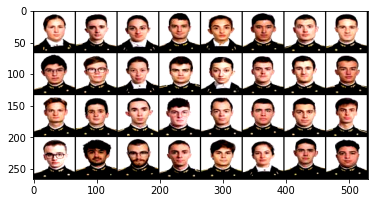

In [61]:
evaluator = Evaluator(device, auto_encoder, dataset) # Create en Evaluator instance to evaluate our trained model
evaluator.reconstruct() # Reconstruct our images from the embedded space

img = make_grid(evaluator._valid_originals.cpu()+0.5)
plt.imshow(img.permute(1, 2, 0))

evaluator.save_original_images_plot(results_path + os.sep + original_images_name) # Save the original images for comparaison purpose
evaluator.save_validation_reconstructions_plot(results_path + os.sep + validation_images_name) # Reconstruct the decoded images and save them


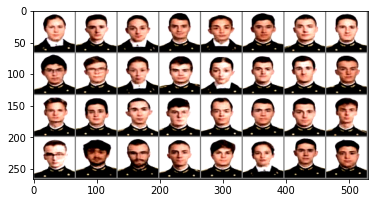

In [62]:
img2 = make_grid(evaluator._valid_reconstructions.cpu().data)+0.5
plt.imshow(img2.permute(1, 2, 0))

In [ ]:
# class Encoder(nn.Module):
#     def __init__(self, num_embeddings, embedding_dim):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 28, kernel_size=3, stride=2, padding=1)
#         self.conv2 = nn.Conv2d(28, 64, kernel_size=3, stride=2, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
#         self.conv4 = nn.Conv2d(128, embedding_dim, kernel_size=1, stride=1)
#         self.embedding = nn.Embedding(num_embeddings, embedding_dim)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = self.conv4(x)
#         return x

# class Decoder(nn.Module):
#     def __init__(self, num_embeddings, embedding_dim):
#         super().__init__()
#         self.conv1 = nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
#         self.conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
#         self.conv3 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
#         self.conv4 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1, output_padding=1)

#     def forward(self, x):
#         x = x.permute(0, 3, 1, 2)
#         print(x.shape)
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = self.conv3(x)
#         x = F.relu(x)
#         x = self.conv4(x)
#         x_recon = F.sigmoid(x)
#         print(x_recon.shape)
#         return x

# class VQ(nn.Module):
#     def __init__(self, device, num_embeddings, embedding_dim, beta):
#         super().__init__()
#         self.device = device
#         self.num_embeddings = num_embeddings
#         self.embedding_dim = embedding_dim
#         self.embedding = nn.Embedding(num_embeddings, embedding_dim)
#         self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
#         self.beta = beta

#     def forward(self, z):
#         # Convert inputs from BCHW -> BHWC
#         z = z.permute(0, 2, 3, 1).contiguous()
#         z_shape = z.shape
        
#         # Flatten input
#         flat_input = z.view(-1, self.embedding_dim)
        
#         # Calculate distances between encoding and embedding space
#         distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
#             + torch.sum(self.embedding.weight**2, dim=1)
#             - 2 * torch.matmul(flat_input, self.embedding.weight.t()))
            
#         # finding the indices 
#         encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
#         encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings).to(self.device)
#         encodings.scatter_(1, encoding_indices, 1)
        
#         # Quantize and unflatten, with one_hot_encodding
#         quantized = torch.matmul(encodings, self.embedding.weight).view(z_shape)
        
#         # Loss
#         e_latent_loss = torch.mean((quantized.detach() - z)**2)
#         q_latent_loss = torch.mean((quantized - z.detach())**2)
#         loss = q_latent_loss + self.beta * e_latent_loss
        
#         # In that way, the gradient will be equal to the z one, but the result will be quantized
#         quantized = z + (quantized - z).detach()
#         avg_probs = torch.mean(encodings, dim=0)
#         perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
#         # Convert quantized from BHWC -> BCHW
#         return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings


# class VQVAE(nn.Module):
#     def __init__(self, device, num_embeddings, embedding_dim, beta):
#         super(VQVAE, self).__init__()
#         self.encoder = Encoder(num_embeddings, embedding_dim)
#         self.vq = VQ(device, num_embeddings, embedding_dim, beta)
#         self.decoder = Decoder(num_embeddings, embedding_dim)
        
#     def forward(self, x):
#         z = self.encoder(x)
#         print(f'z.shape : {z.shape}') # 128, 4, 4, 32
#         # z = self._pre_vq_conv(z) ?
#         loss, quantized, perplexity, encodings = self.vq(z)
#         x_recon = self.decoder(quantized)
#         return loss, x_recon, perplexity


In [ ]:
# num_epochs = 10
# batch_size = 128
# learning_rate = 1e-3
# num_embeddings = 512
# embedding_dim = 32
# beta = 0.25

# train_dataset = MNIST(root='data', train=True, download=True, transform=ToTensor())
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



In [ ]:
# model = VQVAE(device, num_embeddings, embedding_dim, beta).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# for epoch in range(num_epochs):
#     for i, (images, _) in enumerate(tqdm(train_loader)):
#         optimizer.zero_grad()

#         loss_vq , x_recon, perplexity = model(images.to(device))
#         recon_loss = torch.mean((x_recon - images)**2) / train_loader.train_data_variance
#         loss = loss_vq + recon_loss

#         #recon_loss, commit_loss = vq_vae_loss(x_recon, images.to(device), beta, encoding_indices, latents)
#         #loss = recon_loss + beta * commit_loss
#         loss.backward()
#         optimizer.step()
    
#         if (i+1) % 100 == 0:
#           print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, Commit Loss: {:.4f}" 
#                   .format(epoch+1, num_epochs, i+1, len(train_loader), recon_error.item()/len(images), model.loss.item()/len(images)))

#     if i % 100 == 0:
#         print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(train_loader)}] Loss: {loss.item()}")


  0%|          | 0/469 [00:06<?, ?it/s]

z.shape : torch.Size([128, 32, 4, 4])
torch.Size([128, 4, 32, 4])


RuntimeError: ignored

In [ ]:
# test_dataset = MNIST(root='data', train=False, download=True, transform=ToTensor())
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# reconstruction_loss = 0
# with torch.no_grad():
#     for images, _ in test_loader:
#         x_recon, _ = model(images.to(device))
#         reconstruction_loss += F.mse_loss(x_recon, images.to(device), reduction='sum')     
#         reconstruction_loss /= len(test_dataset)
#         print(f"Test Set Reconstruction Loss: {reconstruction_loss.item()}")


z.shape : torch.Size([128, 32, 4, 4])
torch.Size([128, 4, 32, 4])


RuntimeError: ignored

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

# with torch.no_grad():
#     for images, _ in test_loader:
#         x_recon, _ = model(images.to(device))
#         x_recon_cpu = x_recon.cpu()
#         # transformer le tensor en un tableau Numpy
#         x_np = x_recon_cpu.numpy()
#         image_ini = images.numpy()
#         # créer une grille d'images de taille 16 x 8 (128 images)
#         fig, axes = plt.subplots(nrows=16, ncols=8, figsize=(16, 32))

#         # parcourir les images et les afficher dans la grille
#         for i in range(16):
#             for j in range(8):
#                 # obtenir l'image
#                 img = x_np[i*8+j, 0]
#                 # afficher l'image sur l'axe correspondant
#                 axes[i, j].imshow(img, cmap='gray')
#                 # supprimer les axes
#                 axes[i, j].axis('off')

#                 # img = image_ini[i*8+j+1, 0]
#                 # # afficher l'image sur l'axe correspondant
#                 # axes[i, j+1].imshow(img, cmap='gray')
#                 # # supprimer les axes
#                 # axes[i, j+1].axis('off')

#                 # # afficher la grille d'images
#                 # plt.show()
#                 # break

#         plt.show()
#         break



z.shape : torch.Size([128, 32, 4, 4])
torch.Size([128, 4, 32, 4])


RuntimeError: ignored